# Speed Limit Recognizer
### A Convolutional Neural Network to discern speed limits given an image of a speed limit sign.
kward

## Dataset

### Dataset
This model was trained on the [Cropped Speed Limit Signs dataset](https://www.kaggle.com/datasets/shaktip258/cropped-speed-limit-signs) by Shakti Patel

Which includes: 
  - 587 images for 25mph signs
  - 157 images for 30mph signs
  - 141 images for 35mph signs
  - 87  images for 40mph signs
  - 77  images for 45mph signs
  - 48  images for 50mph signs

### Train / Test / Validation Split

The model was trained with a 70/10/20 split for training, testing, and validation data respectively.
Resulting in:
  - 767 training samples
  - 216 validation samples
  - 106 testing samples

## Setup

### Import required packages

In [2]:
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from ann_visualizer.visualize import ann_viz
from Preprocess import loadDataset, reshape_data, split_dataset


# Validate tensorflow version
print(f"Tensorflow loaded! version: {tf.__version__}")

Tensorflow loaded! version: 2.8.0


### Load / Preprocess data

In [5]:
print(f"\nLOADING DATASET...")

dataset = loadDataset(image_dims=[64,64])

# Split dataset
train_pct = 0.7
test_pct = 0.1
valid_pct = 0.2
train_data, test_data, valid_data = split_dataset(dataset, train_pct, test_pct, valid_pct)

print(f"\nDataset loaded!\n")
print(f"Data split: {round(train_pct*100,2)}% train, {round(test_pct*100,2)}% test, {round(valid_pct*100,2)}% valid")
print(f"\n{len(train_data)} training samples\t{len(test_data)} testing samples\t{len(valid_data)} validation samples")


LOADING DATASET...

Dataset loaded!

Data split: 70.0% train, 10.0% test, 20.0% valid

765 training samples	106 testing samples	216 validation samples


#### Random Sample

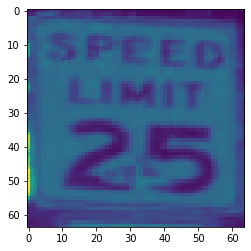

In [3]:
# Pick a random sample from the dataset
def random_sample(data):
  return random.choice(data)["image"]

r_sample = random_sample(valid_data)
plt.imshow(r_sample)

## Model

### Description:
This model is a relatively simple CNN designed to determine the speed limit on a road given an image of the speed limit sign. The model was trained on images of U.S. speed limit signs but could work for others as well.

### Design:
The model is a CNN consisting of a 2D convolutional input layer which is given a grayscaled 64x64 pixel image of a speed limit sign followed by a max-pooling layer. The theory behind this layer pair is that the max pooling will help the network better highlight sharper features extracted from the 1st conv. layer such as edges and textures. These are then passed to another convolutional-pooling layer pair. Though this pair uses average pooling to help the network highlight features such as contours and rounded shapes. Next, these are upsampled to help maintain important features before being flattened and fed into the MLP part of the network.

Each convolutional layer was given 32 3x3 filters/kernels to train. While the max pool layer uses a 4x4 kernel and the average pool layer uses a 3x3 kernel.

The **first hidden layer in the MLP has 4096 neurons**, this number was chosen as it's a power of two and is equal to $ Image Size^{2} $. Thus, 1 neuron per pixel.

**Each hidden layer following has a factor of $ \frac{1}{2}x\ $, $ \frac{1}{4}x\ $, $ \frac{1}{8}x\ $, neurons respectively**. The idea behind this was to allow the network to slowly converge onto a feature set it finds best for classifying the images as the feature map is passed through the MLP. The reason for making them $ \frac{1}{2}\ $, $ \frac{1}{4}\ $, and $ \frac{1}{8}\ $ is to help maintain the power-of-2 nature of the model's design. The theory behind this is that computers work soley in powers of 2 and maintaining this across the network structure could allow for quicker and more efficient operations at the hardware level. Thus, eventually relaying some of this increase in efficiency to the model's training perfomance. *In theory.*

### Loss Function:
Catergorical Cross-Entropy was chosen because it provides a relative ratio of classified/misclassified labels in a multi-label classification task. 
Basically, it's a metric that represents how many samples of each class are labelled correctly/incorrectly relative to the entire training set. 

Each class can be thought of as a 'category'

### Hyperparameters
The network was **trained using the Adam optimizer**. For this, the optimizer paramters m1_decay (*beta_1* in the paper), m2_decay (*beta_2* in the paper), and stabilizer (*epsilon* in the paper) to the defaults set forth by Kingma and Ba. To spare the mathematical details which can be found in the paper linked under the 'Resources' section, Adam was chosen simply because it's currently one of, if not the best stochastic optimizer available.

For the **main activation function we elected to use ReLu** as it is commonly used in CNNs for its linearity and is easily differentiable which also allows it to be fast when backpropagating.

However, the model's **output layer uses softmax activation** as we wanted our output to be a probability distribution over the possible classes (25mph, 30mph, 35mph, 40mph ,45mph, 50mph). Of course with the highest probability being the predicted class (in one-hot encoded form).

The **learning rate was set initially to 0.0001**, 10x less than Adam's default to allow for slower, yet more precise training as our dataset was rather limited. It was **eventually updated to 0.000105** to slightly increase step sizes. 


A **batch size of 10 samples** was chosen for a few reasons:
- Our training set is relatively small and we want to avoid the potential variance that can arise from training on a large number of samples per epoch with a limited training set. 
- Since our **training set was ~750 samples** and with **750 training epochs**, this allowed for an even distribution of ~75 samples/epoch across the training process. In turn, increasing stability and enhancing the effectiveness of data shuffling between epochs. *In theory.* 
- 10 is a cool number

### Create Model

In [14]:
# Model class
class SpeedLimitCNN:

  # Initialize model
  def __init__(self, train_data, test_data, valid_data):
    # Inputs and labels
    self.train_inputs = [sample["image"] for sample in train_data]
    self.train_labels = [int(sample["label"]) for sample in train_data]
    self.test_inputs = [sample["image"] for sample in test_data]
    self.test_labels = [int(sample["label"]) for sample in test_data]
    self.valid_inputs = [sample["image"] for sample in valid_data]
    self.valid_labels = [int(sample["label"]) for sample in valid_data]
  
    # Other variables
    self.model_dir = "models/"
    self.image_dims = np.array(train_data[0]['image']).shape
    labels = np.unique(self.train_labels)

    """
    One hot encode labels.

    [1,0,0,0,0,0] = 25mph
    [0,1,0,0,0,0] = 30mph
    [0,0,1,0,0,0] = 35mph
    [0,0,0,1,0,0] = 40mph
    [0,0,0,0,1,0] = 45mph
    [0,0,0,0,0,1] = 50mph
    """
    _train_labels = []
    for j in range(len(self.train_labels)):
      for i, label in enumerate(labels):
        if self.train_labels[j] == label:
          one_hot = np.zeros(len(labels), dtype=int)
          one_hot[i] = 1
          _train_labels.append(one_hot)
    self.train_labels = _train_labels

    _test_labels = []
    for j in range(len(self.test_labels)):
      for i, label in enumerate(labels):
        if self.test_labels[j] == label:
          one_hot = np.zeros(len(labels), dtype=int)
          one_hot[i] = 1
          _test_labels.append(one_hot)
    self.test_labels = _test_labels

    _valid_labels = []
    for j in range(len(self.valid_labels)):
      for i, label in enumerate(labels):
        if self.valid_labels[j] == label:
          one_hot = np.zeros(len(labels), dtype=int)
          one_hot[i] = 1
          _valid_labels.append(one_hot)
    self.valid_labels = _valid_labels

    # Hyperparameters
    self.epochs = 500                       #   Number of training epochs
    self.batch_size = 10                    #   Number of samples to train per epoch
    self.n_hidden = 4096                    #   Number of nodes in the first hidden layer
    self.n_outputs = 6                      #   6 outputs, 1 for each speed limit
    self.hidden_activation = 'relu'         #   Activation function for hidden layers
    self.output_activation = 'softmax'      #   Output activation (softmax because we want a multi-class probability distribution as our output)
    self.learning_rate = 0.000105           #   Learning rate for training the model
    self.m1_decay = 0.99                    #   First moments decay (specifically for Adam and Adamax optimizers)
    self.m2_decay = 0.999                   #   Second moments decay (also specifically for Adam/Adamax optimizers)
    self.stabilizer = 1e-07                 #   Numerical constant for avoiding 0s and stabilizing parameter updates
    self.n_filters = 32                     #   Number of convolutional filters to apply/train
    self.filter_shape = [3,3]               #   Shape of kernel for conv. filter
    self.max_pool_shape = [4,4]             #   Shape of matrix for applying max pooling 
    self.avg_pool_shape = [3,3]             #   Shape of matrix for applying average pooling

    # Configure training algorithim (optimizer)
    self.optimizer = tf.keras.optimizers.Adam(
                                                self.learning_rate,
                                                self.m1_decay,
                                                self.m2_decay,
                                                self.stabilizer
                                                )
    
    """
      Set loss function. 
      
      Catergorical Cross-Entropy was chosen because it provides a relative ratio of 
      misclassified labels in a multi-class classification task. Basically, it's
      a metric that represents how many samples of each class are labelled correctly/incorrectly
      relative to the entire training set. 

      Each class can be thought of as a 'category'
    """
    self.loss_func = tf.keras.losses.CategoricalCrossentropy()


    # Model
    self.model = tf.keras.models.Sequential([
        # Apply first set of convolutional filters to the inputs
        tf.keras.layers.Conv2D(self.n_filters,self.filter_shape,activation=self.hidden_activation,input_shape=(self.image_dims[0],self.image_dims[1],1),padding='same'),

        # Apply max pooling to extract sharper parts of the images such as edges
        tf.keras.layers.MaxPool2D(self.max_pool_shape),

        # Apply another set of conv. filters to learn from the features extracted from the max pool layer
        tf.keras.layers.Conv2D(self.n_filters,self.filter_shape,activation=self.hidden_activation,input_shape=(self.image_dims[0],self.image_dims[1],1),padding='same'),

        # Apply average pooling to extract smoother parts of the image such as contours and rounded shapes
        tf.keras.layers.AveragePooling2D(self.avg_pool_shape),

        # Upsample resulting image to help preserve extracted features
        tf.keras.layers.UpSampling2D(size=1),

        # Flatten inputs for feeding into the DNN
        tf.keras.layers.Flatten(),

        # First DNN hidden layer
        tf.keras.layers.Dense(units = self.n_hidden, activation = self.hidden_activation, kernel_regularizer='l2'),

        # Second hidden layer
        tf.keras.layers.Dense(units = self.n_hidden/2, activation = self.hidden_activation, kernel_regularizer='l2'),

        # Third hidden layer
        tf.keras.layers.Dense(units = self.n_hidden/4, activation = self.hidden_activation, kernel_regularizer='l2'),

        # Third hidden layer
        tf.keras.layers.Dense(units = self.n_hidden/8, activation = self.hidden_activation, kernel_regularizer='l2'),

        # Output layer
        tf.keras.layers.Dense(units = self.n_outputs, activation = self.output_activation)
    ])

  # Reshape data for use as inputs into the model
  def reshape_data(self, data, image_shape=64):
    return np.reshape(data, [-1, image_shape, image_shape])

  # Train the model
  def train(self):
    # Compile model with optimizer,loss function, and accuracy metrics
    self.model.compile(optimizer=self.optimizer, loss=self.loss_func, metrics=['categorical_accuracy'])
    
    print(f"\n\nTRAINING MODEL...\n")

    # Cast data to numpy array's so tensorflow stops yelling at me
    self.train_inputs = np.array(self.train_inputs)
    self.train_labels = np.array(self.train_labels)
    self.valid_inputs = np.array(self.valid_inputs)
    self.valid_labels = np.array(self.valid_labels)
    self.test_inputs = np.array(self.test_inputs)
    self.test_labels = np.array(self.test_labels)

    # Train model
    self.model.fit(
        x = self.train_inputs,                    # Training inputs
        y = self.train_labels,                    # Training labels,
        epochs = self.epochs,                     # Set number of training epochs
        verbose = 2,                              # How much information to print out about training progress
        shuffle = True,                           # Shuffle training data between epochs
        batch_size = self.batch_size,             # Set number of samples to train per epoch
        validation_data = [self.reshape_data(self.valid_inputs), self.valid_labels],
        use_multiprocessing = True
      )

    print(f"\nEVALUATING MODEL...")
    # Evaluate model on test set
    loss, acc = self.model.evaluate(self.reshape_data(self.test_inputs), self.test_labels)
    threshold = 0.9

    # Save model
    if acc > threshold:
      model_name = f"SpeedLimitCNN_Acc-{round(acc*100.0)}pct.model"
      tf.keras.models.save_model(self.model, self.model_dir + model_name)
      print(f"\nMODEL SAVED TO {self.model_dir+model_name}")
    else:
      print(f"\nMODEL FAILED TO ACHIEVE {round(threshold*100.0,2)}% ACCURACY OR HIGHER")


  # Load model from file
  def load_model(self, filename):
    self.model = tf.keras.models.load_model(filename)
    print(f"\n\nMODEL LOADED!\n")


  # Predict speed limit with internal model (assuming it's been trained or loaded)
  def _predict(self, inputs):
    # Cast data to numpy array's so tensorflow stops yelling at me
    inputs = np.array(inputs)
    predictions = []
    labels = [25,30,35,40,45,50]

    # Predict
    outputs = self.model.predict(reshape_data(inputs))

    # Iterate through outputs
    for output in outputs:
      # Round outputs
      output = np.round_(output)

      # Convert one hot encoded output to an integer prediction and add to array
      label_idx = np.argmax(output)
      predictions.append(labels[label_idx])

    # Return predictions
    return predictions

  # Predict using a given model
  @staticmethod
  def predict(model, inputs):
    # Cast data to numpy array's so tensorflow stops yelling at me
    inputs = np.array(inputs)
    predictions = []
    labels = [25,30,35,40,45,50]

    # Predict
    outputs = model.predict(reshape_data(inputs))

    # Iterate through outputs
    for output in outputs:
      # Round outputs
      output = np.round_(output)

      # Convert one hot encoded output to an integer prediction and add to array
      label_idx = np.argmax(output)
      predictions.append(labels[label_idx])

    # Return predictions
    return predictions
  
cnn = SpeedLimitCNN(train_data, test_data, valid_data)

### Train / Evaluate model



MODEL LOADED!



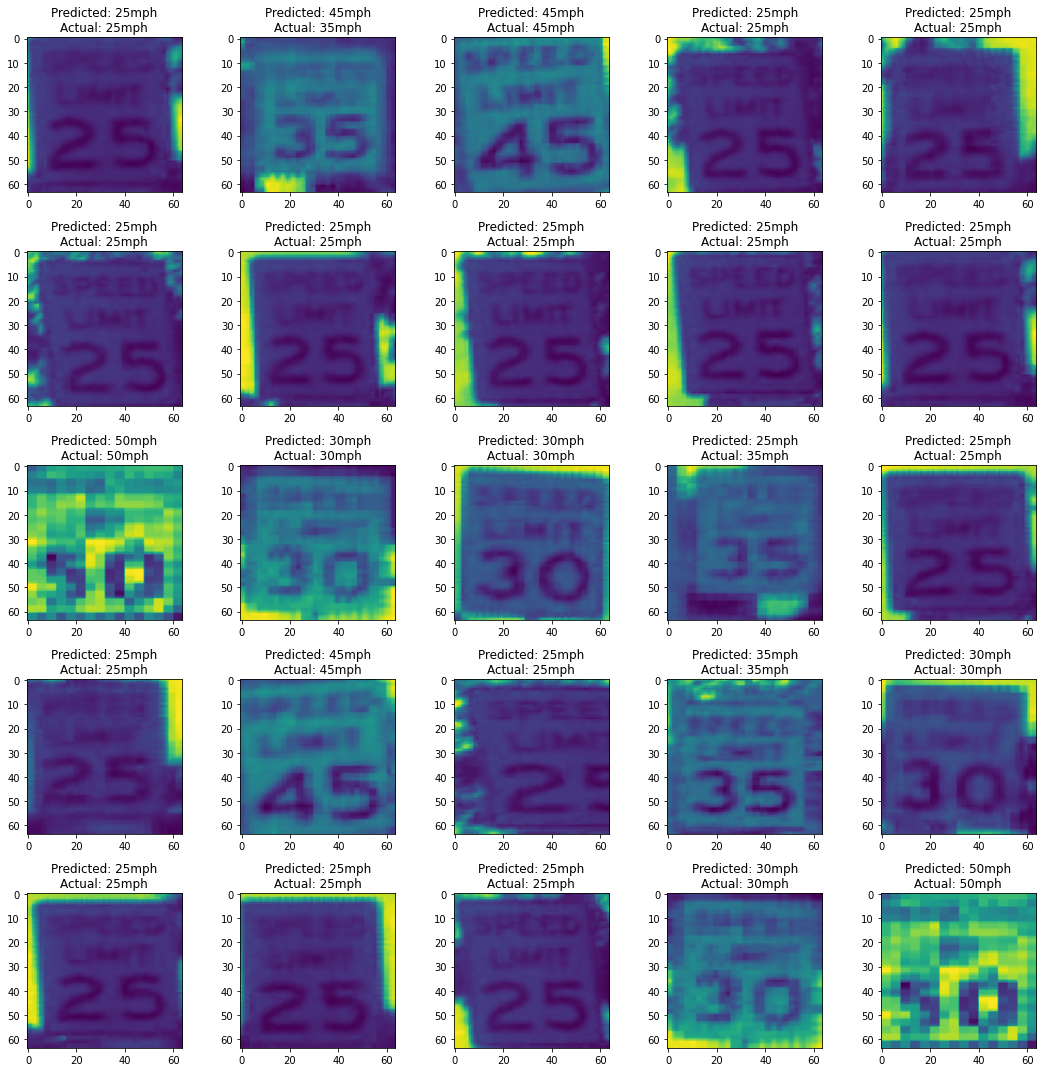

In [26]:
# Load model
cnn.load_model("./models/SpeedLimitCNN_Acc-90pct.model")
n = 25  # Number of random samples
samples = []

# Pick n random samples from the test set
for i in range(n):
    samples.append(random.choice(test_data))
    
# Create figure for plots
rows = int(n/5)
cols = 5

fig, axs = plt.subplots(rows, cols, figsize=(18,15))    

# Predict speed limit for each sample and display results
for i, sample in enumerate(samples):
    axs[i//cols,i%cols].imshow(sample["image"])
    axs[i//cols,i%cols].set_title(f"Predicted: {cnn._predict(sample['image'])[0]}mph\nActual: {sample['label']}mph")

fig.tight_layout()